## Purpose
By taking a directory of SEM images from a given experiment, we want to segment AND classify every image such that we can begin looking at the data as a whole

In [1]:
# General Imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
import pandas as pd 
import matplotlib.pyplot as plt 
import scipy.stats as stat
import numpy as np 
#import forestsci
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from collections import Counter
import pickle
import glob
import copy

import sys
sys.path.append("..")
from Utility.segmentation_utils import * 

image_folder = "../Images/Additional" # Path to folder, adjust for other machines
result_folder = "../Results"
model_folder = "../Models"
image_list_Si = glob.glob(f'{image_folder}/Si embed/*')
image_list_Yuanwei = glob.glob(f'{image_folder}/Images to rachel (from Yuanwei)/*/*') # Might want to separate this?



In [2]:
# Define which image paths to run
RC_files = ["L1 2.5, 5, 10 nM mixing assembly","L2 2.5, 5, 10 nM"]
parent_experiment = RC_files[1]
all_experiments = glob.glob(os.path.join(image_folder,parent_experiment,"*"))
#all_experiments = [glob.glob(os.path.join("../Images/Training/*"))]
print(all_experiments)

# Load models
model_names = ["RF_C-MC_I-P.sav","RF_C_MC.sav","RF_I_P.sav"]
rf_CMC_IP, rf_C_MC, rf_I_P = [pickle.load(open(os.path.join(model_folder,model), 'rb'))\
                              for model in model_names]

# Define Features WHICH MUST MATCH WHAT ALL THREE MODELS WERE TRAINED ON
features=['area',
#        'equivalent_diameter', 
#        'orientation', 
    'major_axis_length',
    'minor_axis_length',
    'perimeter',
#        'min_intensity',
#        'mean_intensity',
        'max_intensity',
    'solidity',
    'major_axis_length/minor_axis_length',
    'perimeter/major_axis_length',
    'perimeter/minor_axis_length',
          'feret_diameter_max',
      'moments_hu-0',
      'moments_hu-1',
      'moments_hu-2',
      'moments_hu-3',
#      'moments_hu-4',
      'moments_hu-5',
#      'moments_hu-6',
#    'eccentricity'
         ]

['../Images/Additional/L2 2.5, 5, 10 nM/L2 5 nM', '../Images/Additional/L2 2.5, 5, 10 nM/L2 2.5nM', '../Images/Additional/L2 2.5, 5, 10 nM/L2_10nM_Low mag.bmp', '../Images/Additional/L2 2.5, 5, 10 nM/L2 10nM']


/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [3]:
# Define key helper functions
def assign_label(predicted_data,mode="C-MC_I-P"):
    '''
    Given an array of arrays, get the max column, associate that with a name, and return the fully labeled list
    Should work with 3 given modes
    '''
    valid_modes = ["C-MC_I-P","C_MC","I_P"]
    if mode not in valid_modes:
        print(f'Error: {mode} not supported')
        return -1
    label_arr = []
    for data in predicted_data:
        index = np.argmax(data)
        if mode == valid_modes[0]:
            if index == 0:
                label_arr.append("Crystal")
            if index == 1:
                label_arr.append("Incomplete")
                
        elif mode == valid_modes[1]:
            if index == 0:
                label_arr.append("Crystal")
            if index == 1:
                label_arr.append("Multiple Crystal")
                
        elif mode == valid_modes[2]:
            if index == 0:
                label_arr.append("Incomplete")
            if index == 1:
                label_arr.append("Poorly Segmented")
    return label_arr

def apply_coloring(IS,df_labeled):
    '''
    To aid study of an image, apply a colored filter over image such that we can see which regions
    are classified as which
    Make borders slightly darker
    '''
    C_color = np.array([0,255,0])
    MC_color = np.array([255,255,0])
    I_color = np.array([255,0,0])
    P_color = np.array([0,0,255])
    color_arr = [C_color,MC_color,I_color,P_color]
    match_arr = ["Crystal","Multiple Crystal", "Incomplete", "Poorly Segmented"]
    
    region_arr = IS.grab_region_array(focused=False)
    mod_image = cv2.cvtColor(IS.img2,cv2.COLOR_BGR2RGB)
    mask_image = copy.deepcopy(mod_image)*0
    for ii in np.arange(len(labeled_arr)):
            id_label = df_labeled.at[ii,"Labels"] # assumed sorted
            color = color_arr[match_arr.index(id_label)]
            mask_image[region_arr[ii] > 0] = color
    
    final_image = cv2.addWeighted(mod_image,.5,mask_image,.5,0)
    return final_image    

In [4]:
debug = []
for experiment in all_experiments:
    print(experiment)
    df_experiment = pd.DataFrame()
    experiment_images = glob.glob(os.path.join(experiment,'*')) # Beware non-images
    
    for individual_image in experiment_images:
        print(individual_image)
        IS = ImageSegmenter(individual_image)
        df_image = IS.df

        # Numerical errors (divide by 0)
        df_image.replace([np.inf, -np.inf], np.nan, inplace=True)
        for feature in features:
            df_image.dropna(subset=[feature],inplace=True)
            
        ### Split Crystal & Multicrystal from Incomplete & Poorly Segmented###
        # Split Data
        X=df_image[features]

        predicted_data = rf_CMC_IP.predict(X)
        labeled_arr = assign_label(predicted_data)
        df_image['Labels'] = labeled_arr
        print("BIG SEPARATOR")
        print(np.unique(labeled_arr))
        
        #### Subdividing further ####
        df_image_sublist = []
        for label in ['Crystal','Incomplete']:
            df_image_temp = df_image[df_image['Labels'] == label]
            rf_temp = rf_C_MC if label == 'Crystal' else rf_I_P
            label_mode = "C_MC" if label == 'Crystal' else "I_P"
            X_temp = df_image_temp[features]

            try:
                predicted_data_temp = rf_temp.predict(X_temp)
            except:
                print(f'Prediction failed on {label}, maybe 0 elements?')
                predicted_data_temp = []
            print(predicted_data_temp)
            labeled_arr = assign_label(predicted_data_temp,mode=label_mode)
            df_image_temp['Labels'] = labeled_arr
            print(np.unique(df_image_temp["Labels"]))
            df_image_sublist.append(df_image_temp)

        df_image = pd.concat(df_image_sublist)
        df_image.sort_values(by="Region",inplace=True)
        debug = (individual_image,df_image)

        df_experiment = pd.concat([df_experiment,df_image])
    print(np.unique(df_image["Labels"]))
    df_experiment.to_csv(os.path.join(result_folder,experiment.split("/")[-1]))


../Images/Additional/L2 2.5, 5, 10 nM/L2 5 nM
../Images/Additional/L2 2.5, 5, 10 nM/L2 5 nM/L2_5nM_04.bmp
Image Segmenter on L2_5nM_04 created!


/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.71329365 0.28670635]
 [0.75625    0.24375   ]
 [0.70561756 0.29438244]
 [0.78876488 0.21123512]
 [0.78876488 0.21123512]
 [0.84959077 0.15040923]
 [0.77312128 0.22687872]
 [0.73404018 0.26595982]
 [0.71168155 0.28831845]
 [0.85584077 0.14415923]
 [0.73167783 0.26832217]
 [0.8061756  0.1938244 ]
 [0.73954613 0.26045387]
 [0.80898437 0.19101563]
 [0.9172619  0.0827381 ]
 [0.74959077 0.25040923]
 [0.89637277 0.10362723]
 [0.81158854 0.18841146]
 [0.75695685 0.24304315]
 [0.81077009 0.18922991]
 [0.64976438 0.35023562]
 [0.84021577 0.15978423]
 [0.59412202 0.40587798]
 [0.78954613 0.21045387]
 [0.76886161 0.23113839]
 [0.73240327 0.26759673]
 [0.68092138 0.31907862]
 [0.72998512 0.27001488]
 [0.

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: divide by zero encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.78417897 0.21582103]
 [0.86104911 0.13895089]
 [0.43322793 0.56677207]
 [0.63259549 0.36740451]
 [0.84542411 0.15457589]
 [0.76026786 0.23973214]
 [0.83234747 0.16765253]
 [0.53369296 0.46630704]
 [0.62441096 0.37558904]
 [0.80059524 0.19940476]
 [0.64163566 0.35836434]
 [0.76702009 0.23297991]
 [0.91013765 0.08986235]
 [0.79317336 0.20682664]
 [0.67625248 0.32374752]
 [0.8484189  0.1515811 ]
 [0.79475446 0.20524554]
 [0.72282366 0.27717634]
 [0.86032366 0.13967634]
 [0.76052827 0.23947173]
 [0.72678571 0.27321429]
 [0.6655754  0.3344246 ]
 [0.81809896 0.18190104]
 [0.61622644 0.38377356]
 [0.78642113 0.21357887]
 [0.84308036 0.15691964]
 [0.75070685 0.24929315]
 [0.85063244 0.14936

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.84021577 0.15978423]
 [0.64502108 0.35497892]
 [0.77302827 0.22697173]
 [0.78368676 0.21631324]
 [0.66062748 0.33937252]
 [0.72842262 0.27157738]
 [0.72072173 0.27927827]
 [0.69559772 0.30440228]
 [0.60039683 0.39960317]
 [0.77927827 0.22072173]
 [0.72232143 0.27767857]
 [0.75712426 0.24287574]
 [0.67836682 0.32163318]
 [0.84655878 0.15344122]
 [0.73422619 0.26577381]
 [0.62893105 0.37106895]
 [0.74315476 0.25684524]
 [0.76467634 0.23532366]
 [0.7656064  0.2343936 ]
 [0.80117187 0.19882813]
 [0.90874256 0.09125744]
 

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.54024058 0.45975942]
 [0.81300223 0.18699777]
 [0.78266369 0.21733631]
 [0.85063244 0.14936756]
 [0.50986483 0.49013517]
 [0.84542411 0.15457589]
 [0.85604539 0.14395461]
 [0.54559772 0.45440228]
 [0.7453869  0.2546131 ]
 [0.67729415 0.32270585]]
['Crystal']
[[0.50022321 0.49977679]
 [0.5859003  0.4140997 ]
 [0.59821429 0.40178571]
 [0.65259177 0.34740823]
 [0.60552455 0.39447545]
 [0.58688616 0.41311384]
 [0.49884673 0.50115327]
 [0.72988591 0.27011409]
 [0.65824653 0.34175347]
 [0.69962629 0.30037371]
 [0.82916667 0.17083333]
 [0.56158854 0.43841146]
 [0.5687376  0.4312624 ]
 [0.59627413 0.40372587]
 [0.67888765 0.32111235]
 [0.77544643 0.22455357]
 [0.46523438 0.53476562]
 [0.57139757 0.42860243]
 [0.82868755 0.17131245]]
['Incomplete' 'Poorly Segmented']
../Images/Additional/L2 2.5, 5, 10 nM/L2 5 nM/L2_5nM_07.bmp
Image Segmenter on L2_5nM_07 created!


/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.76104911 0.23895089]
 [0.54762525 0.45237475]
 [0.68892609 0.31107391]
 [0.73063616 0.26936384]]
['Crystal']
[[0.52483259 0.47516741]
 [0.59735863 0.40264137]
 [0.59663318 0.40336682]
 [0.61553819 0.38446181]
 [0.49384301 0.50615699]
 [0.61480655 0.38519345]
 [0.59658358 0.40341642]
 [0.609437   0.390563  ]
 [0.7530878  0.2469122 ]
 [0.77934648 0.22065352]
 [0.79436384 0.20563616]]
['Incomplete' 'Poorly Segmented']
['Crystal' 'Incomplete' 'Poorly Segmented']
../Images/Additional/L2 2.5, 5, 10 nM/L2 2.5nM
../Images/Additional/L2 2.5, 5, 10 nM/L2 2.5nM/L2_2.5nM_03.bmp
Image Segmenter on L2_2.5nM_03 created!
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.70225694 0.29774306]
 [0.75178571 0.24821429]
 [0.5562314  0.4437686 ]
 [0.87427455 0.12572545]
 [0.79575893 0

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.85440848 0.14559152]
 [0.68151042 0.31848958]
 [0.74854911 0.25145089]
 [0.52874504 0.47125496]]
['Crystal']
[[0.52548363 0.47451637]
 [0.49787946 0.50212054]
 [0.55416667 0.44583333]
 [0.46311384 0.53688616]
 [0.58831845 0.41168155]
 [0.53893849 0.46106151]
 [0.63143601 0.36856399]
 [0.58302331 0.41697669]
 [0.51806176 0.48193824]
 [0.49553571 0.50446429]
 [0.5187252  0.4812748 ]
 [0.68233507 0.31766493]
 [0.59699901 0.40300099]
 [0.51153894 0.48846106]
 [0.5218502  0.4781498 ]
 [0.6468006  0.3531994 ]
 [0.86927083 0.13072917]]
['Incomplete' 'Poorly Segmented']
../Images/Additional/L2 2.5, 5, 10 nM/L2 2.5nM/L2_2.5nM_06.bmp
Image Segmenter on L2_2.5nM_06 created!


/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.60380084 0.39619916]
 [0.82470238 0.17529762]
 [0.67854043 0.32145957]
 [0.57801959 0.42198041]
 [0.54046379 0.45953621]
 [0.5827443  0.4172557 ]
 [0.91205357 0.08794643]
 [0.53359995 0.46640005]
 [0.46845858 0.53154142]
 [0.82695312 0.17304688]
 [0.82122396 0.17877604]
 [0.73404018 0.26595982]
 [0.72265625 0.27734375]
 [0.55919519 0.44080481]
 [0.64833209 0.35166791]]
['Crystal' 'Multiple Crystal']
[[0.57447917 0.42552083]
 [0.55820313 0.44179687]
 [0.55299479 0.44700521]
 [0.57799479 0.42200521]
 [0.61542039 0.38457961]
 [0.67931548 0.32068452]
 [0.55755208 0.44244792]
 [0.56861979 0.43138021]
 [0.68097718 0.31902282]
 [0.55651042 0.44348958]
 [0.55585938 0.44414062]
 [0.49508929 0.50491071]
 [0.54635417 0.45364583]
 [0.68705357 0.31294643]
 [0.54453125 0.45546875]
 [0.63271949 0.36728051]
 [0.58580729 

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.68293031 0.31706969]
 [0.56421751 0.43578249]
 [0.51462674 0.48537326]
 [0.74978537 0.25021463]
 [0.68101438 0.31898562]
 [0.67413194 0.32586806]
 [0.73210565 0.26789435]
 [0.51051587 0.48948413]
 [0.63389137 0.36610863]
 [0.68771081 0.31228919]
 [0.56334325 0.43665675]
 [0.67317708 0.32682292]
 [0.7749256  0.2250744 ]
 [0.74078239 0.25921761]
 [0.63655754 0.36344246]
 [0.67357391 0.32642609]
 [0.58713418 0.41286582]
 [0.52123016 0.47876984]
 [0.75811012 0.24188988]
 [0.77979911 0.22020089]
 [0.89190848 0.10809152]
 [0.58318452 0.41681548]
 [0.64833209 0.35166791]
 [0.70446429 0.29553571]
 [0.83630952 0.16369048]
 [0.73028274 0.26971726]
 [0.6564236

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.80731027 0.19268973]]
['Crystal']
[[0.6921565  0.3078435 ]
 [0.7499938  0.2500062 ]
 [0.73481523 0.26518477]
 [0.56979167 0.43020833]
 [0.68563988 0.31436012]
 [0.85517113 0.14482887]
 [0.59278274 0.40721726]
 [0.7094308  0.2905692 ]
 [0.75721106 0.24278894]
 [0.8234003  0.1765997 ]
 [0.91350446 0.08649554]
 [0.64300595 0.35699405]
 [0.70395585 0.29604415]
 [0.6766183  0.3233817 ]
 [0.71421131 0.28578869]
 [0.62460938 0.37539062]
 [0.69800967 0.30199033]
 [0.67470238 0.32529762]
 [0.54032118 0.45967882]
 [0.59735863 0.40264137]
 [0.81729911 0.18270089]
 [0.76311384 0.23688616]
 [0.88723958 0.11276042]
 [0.8250744  0.1749256 ]
 [0.92313988 0.07686012]
 [0.73498884 0.26501116]
 [0.75721106 0.24278894]
 [0.64205729 0.35794271]
 [0.70060764 0.29939236]
 [0.69102013 0.30897987]]
['Incomplete']
../Images/Additional/L2 2.5, 5, 10 nM/L2 10nM/L5_2.5nM_higherT_03.bmp
Image Segmenter on L5_2.5nM_higherT_03 created!
[ 1  2  3  4  5  6  7  8  9 10 11 12 13

/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:170: RuntimeWarning: invalid value encountered in divide
  clusters['major_axis_length/minor_axis_length'] = clusters['major_axis_length']/clusters['minor_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:171: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/major_axis_length'] = clusters['perimeter']/clusters['major_axis_length']
/home/jacob/Desktop/Mirkin/colloidal_crystal_ML/Notebooks/../Utility/segmentation_utils.py:172: RuntimeWarning: invalid value encountered in divide
  clusters['perimeter/minor_axis_length'] = clusters['perimeter']/clusters['minor_axis_length']


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.75706845 0.24293155]
 [0.64100322 0.35899678]
 [0.66929563 0.33070437]
 [0.93409598 0.06590402]
 [0.78995536 0.21004464]
 [0.6296193  0.3703807 ]
 [0.86104911 0.13895089]
 [0.82459077 0.17540923]
 [0.69448165 0.30551835]
 [0.79808408 0.20191592]
 [0.71266741 0.28733259]
 [0.87330729 0.12669271]
 [0.79962798 0.20037202]
 [0.64208209 0.35791791]
 [0.67887143 0.32112857]
 [0.82457217 0.17542783]
 [0.85638021 0.14361979]
 [0.91013765 0.08986235]
 [0.83093378 0.16906622]
 [0.71512277 0.28487723]
 [0.73422619 0.26577381]
 [0.56116691 0.43883309]
 [0.81339286 0.18660714]
 [0.75818452 0.24181548]
 [0.7392385  0.2607615 ]]
['Crystal']
[[0.70442708 0.29557292]
 [0.74654469 0.25345531]
 [0.63834945 0.36165055]
 [0.75342713 0.24657287]
 [0.70598338 0.294

BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.59740203 0.40259797]
 [0.60028522 0.39971478]]
['Crystal']
[[0.63815104 0.36184896]
 [0.66068948 0.33931052]
 [0.57403274 0.42596726]
 [0.6125     0.3875    ]
 [0.66170635 0.33829365]
 [0.59873512 0.40126488]
 [0.65638021 0.34361979]
 [0.70494792 0.29505208]
 [0.50768229 0.49231771]
 [0.50833333 0.49166667]
 [0.59564732 0.40435268]
 [0.64262153 0.35737847]
 [0.55       0.45      ]
 [0.56236979 0.43763021]]
['Incomplete']
../Images/Additional/L2 2.5, 5, 10 nM/L2 10nM/L2_10nM_12.bmp
Image Segmenter on L2_10nM_12 created!
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62]
BIG SEPARATOR
['Crystal' 'Incomplete']
[[0.84949777 0.15050223]
 [0.70133929 0.29866071]
 [0.61758433 0.38241567]
 [0.51847098 0.48152902]
 [0.85063244 0.14936756]
 [0.85584077 0.14415923]
 [0.55752108 0.44247892]
 [0.59492808 0.40507192]
 [0

Image Segmenter on L2_10nM_05 created!
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
['Crystal' 'Incomplete' 'Multiple Crystal' 'Poorly Segmented']


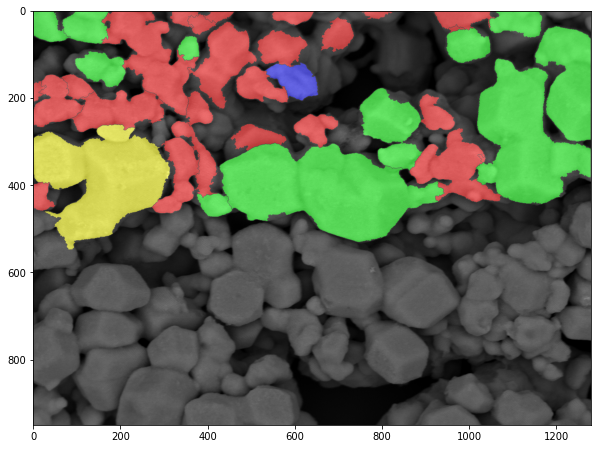

In [5]:
test = apply_coloring(ImageSegmenter(debug[0]),debug[1])
print(np.unique(debug[1]["Labels"]))
plt.figure(figsize = (10,10))
plt.imshow(test)

Image Segmenter on L2_10nM_05 created!


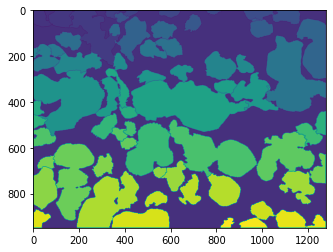

In [6]:
debug_IS = ImageSegmenter(debug[0])
plt.imshow(debug_IS.markers)

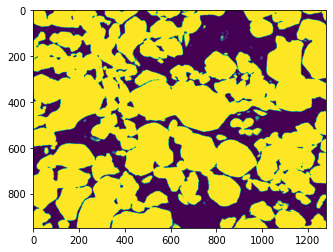

In [7]:
import matplotlib.pyplot as plt
plt.imshow(IS.thresh)

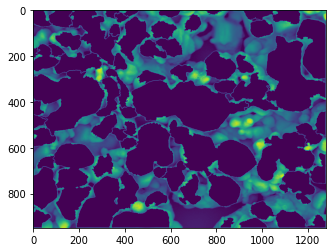

In [8]:
# Quick check so one can see what region was "forgotten" by image segmenter
img_forgotten = copy.deepcopy(IS.img2)
img_forgotten[IS.markers > 10] = 0
plt.imshow(img_forgotten)

In [9]:
# load first RF model from disk
model_name = "../Models/RF_C-MC_I-P.sav"
loaded_model = pickle.load(open(model_name, 'rb'))


/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/jacob/anaconda3/envs/colloidal_crystal/lib/python3.9/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.1.1 when using version 1.1.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Prepare data
df_image_C_MC = df_image[df_image['Labels'] == 'Crystal']
df_image_I_P = df_image[df_image['Labels'] == 'Incomplete']

X_C_MC = df_image_C_MC[features]
X_I_P = df_image_I_P[features]

predicted_data_C_MC = rf_C_MC.predict(X_C_MC)
predicted_data_I_P = rf_I_P.predict(X_I_P)

labeled_arr = assign_label(predicted_data_C_MC)
df_image_C_MC['Labels'] = labeled_arr
labeled_arr = assign_label(predicted_data_I_P)
df_image_I_P['Labels'] = labeled_arr

df_image = pd.concat([df_image_C_MC,df_image_I_P])
df_image.sort_values(by="Region")
df_experiment = pd.concat([df_experiment,df_image])

df = IS.df
#print(np.unique(df["Filename"]))

# Modify Data (Remove illegal data OR set different runtime)

# Numerical errors (divide by 0)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
for feature in features:
    df.dropna(subset=[feature],inplace=True)

# Split Data (TO-DO)
X=df[features]

# Make adjustments to data
X=X # For RF, feature normalization NOT NEEDED

# NOTE (2022.08.24): What do I have to do with the classification afterwards???

#y
#ohe = OneHotEncoder(sparse=False)
#y = ohe.fit_transform(df[[label]])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [10]:

        
labeled_arr = assign_label(predicted_data)
IS.df['Labels'] = labeled_arr
IS.override_exists=True
IS.create_csv()
print(IS._csv_file)

../Results/values_L2_10nM_05.csv


In [11]:
df_Crystal = IS.df[IS.df["Labels"] == "Crystal"]
df_Incomplete = IS.df[IS.df["Labels"] != "Crystal"]
print(f'Num Crystals: {len(df_Crystal)} \nNum Incomplete: {len(df_Incomplete)}')

Num Crystals: 30 
Num Incomplete: 39


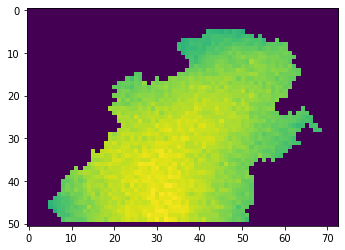

Model Thinks: Incomplete
Next (hit enter)


In [12]:

for ii in np.arange(len(IS.region_arr)):
    clear_output(wait=False)
    plt.imshow(IS.region_arr[ii])
    plt.show()
    print(f'Model Thinks: {labeled_arr[ii]}')
    input('Next (hit enter)')
